<a href="https://colab.research.google.com/github/Gaci-git/Football-Betting-Odds/blob/main/Football_betting_odds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [ ]:
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Football/database.sqlite')

# XML parsing

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
def extract_xml(row,col_name,xml_key,away_home) -> int:
  """Parse XML"""
  count = 0
    
  element = row[col_name]
  team_id = row[away_home + "_team_api_id"]
    
  if type(element) == int:
      return element
    
  elif element != None:
      tree = ET.ElementTree(ET.fromstring(element))
      root = tree.getroot()
        
      for child in root.iter(xml_key):
            
          if str(team_id) == child.text:
                count +=1
      return count
  else:
      return np.nan
        

In [ ]:
def xml_spliter(data_frame, column_name):
  """Split parsed result between home team and away team"""
  for column in column_names:
    data_frame[column + "_away"] = data_frame.apply(lambda x : extract_xml(x,column,"team","away"), axis = 1) 
    data_frame[column + "_home"] = data_frame.apply(lambda x : extract_xml(x,column,"team","home"), axis = 1)
    data_frame.drop(column, axis=1, inplace=True)

# Poisson model

In [ ]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

# Odd counter

In [ ]:
def count_probability(home_team, away_team) -> str:
  """Return propabilities of game outcome"""
  n_vs_a = simulate_match(poisson_model, home_team, away_team, max_goals=5)
  probability = np.sum(np.tril(n_vs_a, -1))
  home_win = 1 / probability


  probability = np.sum(np.diag(n_vs_a))
  draw = 1 / probability

  probability = np.sum(np.triu(n_vs_a, 1))
  away_win = 1 / probability

  return "home_win {}, draw {}, away_win {}.".format(home_win, draw, away_win)




In [ ]:
def give_odds(home_team , away_team) -> pd.DataFrame:
  """Return dataframe with odds stated by 365 gambling company"""
  df = B365_odds[B365_odds['home_team'].str.contains(home_team)]
  df = df[df['away_team'].str.contains(away_team)]
  return df.mean(axis=0)

# Data Exploration

Let's imagine that we are data scientists working in a sports betting company. The business executives in our company after some initial analysis identified a new potential opportunity - betting on football. A European one. 

Let's familiarize ourselves with a football dataset found on [kaggle](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european)  and search for anything that could give us a competitive advantage in the attempt to bet on a successful team and win. We will try to find the best teams in the league, and simulate matches between them!

First, we will get to know what's in the dataset

In [ ]:
football_db = {}

result = con.execute("SELECT name FROM sqlite_master WHERE type='table';")

#Gives list of tables
for table in result:
    query = "SELECT * from " + str(table[0]) + ";"
    football_db[table[0]] = pd.read_sql_query(query, con)
    
football_db.keys()

dict_keys(['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes'])

In [ ]:
df_match = football_db["Match"].copy()
df_match.columns

for col_name in df_match.columns: 
    print(col_name)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

NOTE TO SELF. DONT RANDOMIZE LOGISTIC REGGRESSION SAMPLE

In [ ]:
df_player = football_db["Player_Attributes"].copy()
df_player.columns

for col_name in df_player.columns: 
    print(col_name)

id
player_fifa_api_id
player_api_id
date
overall_rating
potential
preferred_foot
attacking_work_rate
defensive_work_rate
crossing
finishing
heading_accuracy
short_passing
volleys
dribbling
curve
free_kick_accuracy
long_passing
ball_control
acceleration
sprint_speed
agility
reactions
balance
shot_power
jumping
stamina
strength
long_shots
aggression
interceptions
positioning
vision
penalties
marking
standing_tackle
sliding_tackle
gk_diving
gk_handling
gk_kicking
gk_positioning
gk_reflexes


In [ ]:
#how many unique players we have?
df_player = df_player.drop_duplicates()
df_player.shape

(183978, 42)

# Which leagues are in which countries?

In [ ]:
league_country = pd.read_sql('''SELECT c.id, c.name, l.name as league_name, count(DISTINCT t.team_long_name) as teams
FROM Country c
INNER JOIN League l
ON c.id = l.country_id 

INNER JOIN Match m
ON m.country_id = l.country_id 

INNER JOIN Team t
ON m.home_team_api_id = t.team_api_id

GROUP BY c.name
ORDER BY teams desc''', con)
league_country.head(10)

,id,name,league_name,teams
0,4769,France,France Ligue 1,35
1,1729,England,England Premier League,34
2,21518,Spain,Spain LIGA BBVA,33
3,10257,Italy,Italy Serie A,32
4,7809,Germany,Germany 1. Bundesliga,30
5,17642,Portugal,Portugal Liga ZON Sagres,29
6,13274,Netherlands,Netherlands Eredivisie,25
7,1,Belgium,Belgium Jupiler League,24
8,15722,Poland,Poland Ekstraklasa,22
9,19694,Scotland,Scotland Premier League,17


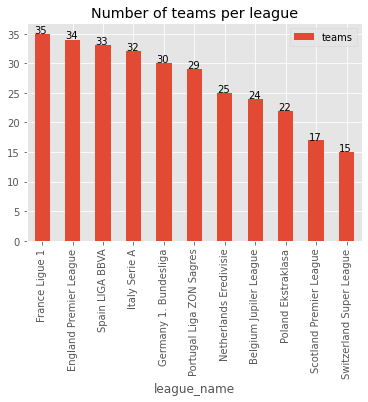

In [ ]:
#@title
plt.style.use('ggplot')
ax = league_country.plot.bar(x="league_name",y="teams",rot=90)

plt.title('Number of teams per league')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.001, p.get_height() * 1.005))
plt.show()

# Which leagues score the most/fewest goals?

In [ ]:
goal_count = pd.read_sql('''SELECT c.name,
l.name as league_name, 
sum(m.home_team_goal) + sum(m.away_team_goal) as goals

FROM Country c
INNER JOIN League l
ON c.id = l.country_id 
INNER JOIN Match m
ON m.country_id = l.country_id 
GROUP BY league_name
ORDER BY goals desc''', con)
goal_count

,name,league_name,goals
0,Spain,Spain LIGA BBVA,8412
1,England,England Premier League,8240
2,Italy,Italy Serie A,7895
3,Netherlands,Netherlands Eredivisie,7542
4,France,France Ligue 1,7427
5,Germany,Germany 1. Bundesliga,7103
6,Portugal,Portugal Liga ZON Sagres,5201
7,Belgium,Belgium Jupiler League,4841
8,Scotland,Scotland Premier League,4804
9,Poland,Poland Ekstraklasa,4656


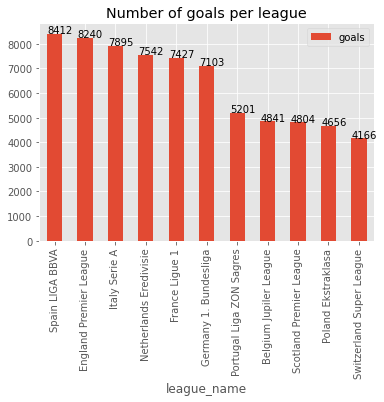

In [ ]:
#@title
plt.style.use('ggplot')

ax = goal_count.plot.bar(x="league_name",y="goals",rot=90)
plt.title('Number of goals per league')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.001, p.get_height() * 1.005))

plt.show()

# Who are the top scorers in each team and league?

In [ ]:
goal_count_t = pd.read_sql('''SELECT c.name, t.team_long_name, 
l.name as league_name, 
sum(m.home_team_goal) + sum(m.away_team_goal) as goals

FROM Country c
INNER JOIN League l
ON c.id = l.country_id 
INNER JOIN Match m
ON m.country_id = l.country_id 
INNER JOIN Team t
ON m.home_team_api_id = t.team_api_id

GROUP BY t.team_long_name
ORDER BY goals desc''', con)
goal_count_t

,name,team_long_name,league_name,goals
0,Spain,Real Madrid CF,Spain LIGA BBVA,652
1,Spain,FC Barcelona,Spain LIGA BBVA,596
2,Netherlands,PSV,Netherlands Eredivisie,496
3,England,Manchester City,England Premier League,490
4,Switzerland,BSC Young Boys,Switzerland Super League,485
...,...,...,...,...
291,Portugal,Uniao da Madeira,Portugal Liga ZON Sagres,36
292,France,Angers SCO,France Ligue 1,35
293,Portugal,Trofense,Portugal Liga ZON Sagres,35
294,Portugal,Feirense,Portugal Liga ZON Sagres,32


In [ ]:
#@title
def goal_counter(df, country):
    df = df[df.name  == country]
    plt.style.use('ggplot')

    df[['name', 'team_long_name', 'goals']].sort_values(['goals'], ascending=False)
    
    df.plot.bar(x="team_long_name",y="goals",rot=90)
    plt.title('Top scorers')
    plt.show()


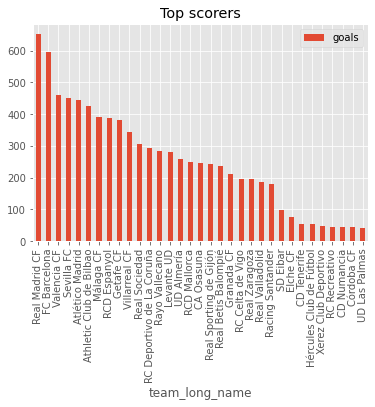

In [ ]:
goal_counter(goal_count_t, 'Spain')

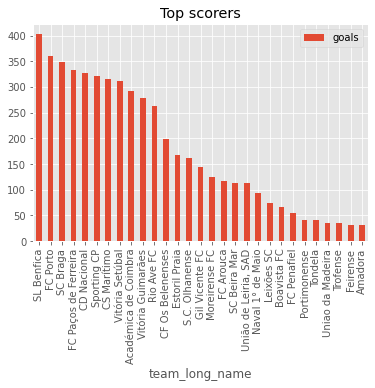

In [ ]:
goal_counter(goal_count_t, 'Portugal')

It seems, that Spain is the leader here - one team with a score of 652 goals.
Although Portugal has a top-bottom 3 teams, many teams have scored more than 200 goals.
Seems like there is no such thing as 'best country in football'.

## Away / home goals

It is said, that understanding how home advantage affects football results is key to finding football betting value and modeling your own football trading odds. We should check if the home advantage is seen in this dataset.

In [ ]:
team_vs_team = pd.read_sql('''SELECT 
Match.season,
th.team_long_name as home_team,
Match.home_team_goal,
ta.team_long_name as away_team,
Match.away_team_goal
FROM Match
JOIN Team AS ta ON Match.away_team_api_id = ta.team_api_id
JOIN Team AS th ON Match.home_team_api_id = th.team_api_id
WHERE Match.country_id = 1729
ORDER BY Match.home_team_api_id desc''', con)
team_vs_team

,season,home_team,home_team_goal,away_team,away_team_goal
0,2008/2009,Newcastle United,2,West Bromwich Albion,1
1,2008/2009,Newcastle United,2,Aston Villa,0
2,2008/2009,Newcastle United,2,Wigan Athletic,2
3,2008/2009,Newcastle United,2,Stoke City,2
4,2008/2009,Newcastle United,2,Tottenham Hotspur,1
...,...,...,...,...,...
3035,2014/2015,Burnley,0,Leicester City,1
3036,2014/2015,Burnley,0,Stoke City,0
3037,2014/2015,Burnley,0,Sunderland,0
3038,2014/2015,Burnley,1,West Ham United,3


Creating Home Win, Draw Win, and Away Win columns that we will use to demonstrate win rates.

In [ ]:
win_rates = team_vs_team.assign(home_win=lambda team_vs_team: team_vs_team.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'),
              draw=lambda team_vs_team: team_vs_team.apply(lambda row: 1 if row.home_team_goal == row.away_team_goal else 0, axis='columns'),
              away_win=lambda team_vs_team: team_vs_team.apply(lambda row: 1 if row.home_team_goal < row.away_team_goal else 0, axis='columns'))

In [ ]:
win_rates = \
(win_rates.groupby('season')
    .mean()
    .loc[:, ['home_win', 'draw', 'away_win']])

win_rates

,home_win,draw,away_win
season,,,
2008/2009,0.455263,0.255263,0.289474
2009/2010,0.507895,0.252632,0.239474
2010/2011,0.471053,0.292105,0.236842
2011/2012,0.450000,0.244737,0.305263
2012/2013,0.436842,0.284211,0.278947
2013/2014,0.471053,0.205263,0.323684
2014/2015,0.452632,0.244737,0.302632
2015/2016,0.413158,0.281579,0.305263


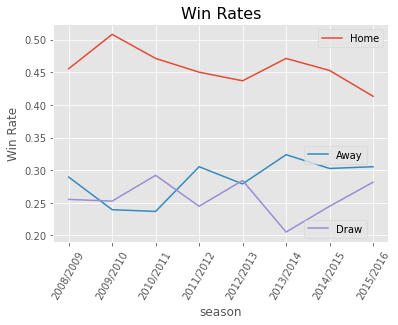

In [ ]:
#@title
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)

home_line = ax.plot(win_rates.home_win, label='Home')
away_line = ax.plot(win_rates.away_win, label='Away')
draw_line = ax.plot(win_rates.draw, label='Draw')
ax.set_xlabel("season")
ax.set_ylabel("Win Rate")
plt.title("Win Rates", fontsize=16)
plt.xticks(rotation = 60)

home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.4))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.95, 0.06))

# Predicting the match result

## Feature engineering

In [ ]:
match_result = pd.read_sql('''SELECT 
Match.away_team_api_id,
Match.home_team_api_id,
Match.date,
Match.shoton,
Match.shotoff,
Match.foulcommit,
Match.card,
Match.cross,
Match.corner,
Match.possession,
th.team_long_name as home_team,
Match.home_team_goal,
ta.team_long_name as away_team,
Match.away_team_goal
FROM Match
JOIN Team AS ta ON Match.away_team_api_id = ta.team_api_id
JOIN Team AS th ON Match.home_team_api_id = th.team_api_id
WHERE Match.country_id = 1729
ORDER BY Match.home_team_api_id desc''', con)

Our dataset has no columns showing the match outcome (win, draw, lost). We will create two columns for the results for each team. One of these would become the target variable for our ML model.

In [ ]:
# create results columns for both home and away teams (W - win, D = Draw, L = Loss).

match_result.loc[match_result['home_team_goal'] == match_result['away_team_goal'], 'home_team_result'] = 'D'
match_result.loc[match_result['home_team_goal'] > match_result['away_team_goal'], 'home_team_result'] = 'W'
match_result.loc[match_result['home_team_goal'] < match_result['away_team_goal'], 'home_team_result'] = 'L'

match_result.loc[match_result['home_team_goal'] == match_result['away_team_goal'], 'away_team_result'] = 'D'
match_result.loc[match_result['home_team_goal'] > match_result['away_team_goal'], 'away_team_result'] = 'L'
match_result.loc[match_result['home_team_goal'] < match_result['away_team_goal'], 'away_team_result'] = 'W'

# Parsing

In [ ]:
match_result.head(1)

,away_team_api_id,home_team_api_id,date,shoton,shotoff,foulcommit,card,cross,corner,possession,home_team,home_team_goal,away_team,away_team_goal,home_team_result,away_team_result
0,8659,10261,2008-10-28 00:00:00,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,Newcastle United,2,West Bromwich Albion,1,W,L


According to the info left in Kaggle, our data was scraped from multiple sources, and some data points are somewhat left in XML populating our columns. Let's parse them with xml.etree.ElementTree.

In [ ]:
column_names = ['shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']

In [ ]:
xml_spliter(match_result, column_names)

In [ ]:
match_result.head(3)

,away_team_api_id,home_team_api_id,date,home_team,home_team_goal,away_team,away_team_goal,home_team_result,away_team_result,shoton_away,...,foulcommit_away,foulcommit_home,card_away,card_home,cross_away,cross_home,corner_away,corner_home,possession_away,possession_home
0,8659,10261,2008-10-28 00:00:00,Newcastle United,2,West Bromwich Albion,1,W,L,5,...,12,15,4,0,15,17,8,7,0,0
1,10252,10261,2008-11-03 00:00:00,Newcastle United,2,Aston Villa,0,W,L,1,...,20,14,3,4,19,11,6,2,0,0
2,8528,10261,2008-11-15 00:00:00,Newcastle United,2,Wigan Athletic,2,D,D,4,...,13,9,4,1,22,23,10,4,0,0


In [ ]:
# Spliting the raw_match_stats to two datasets (home_team_stats and away_team_stats)

home_team_stats = match_result[[
 'date',
 'home_team',
 'home_team_goal',
 'shoton_home',
 'shotoff_home',
 'foulcommit_home',
 'card_home',
 'cross_home',
 'corner_home',
 'possession_home',
 'home_team_result',]]

away_team_stats = match_result[[
 'date',
 'away_team',
 'away_team_goal',
 'shoton_away',
 'shotoff_away',
 'foulcommit_away',
 'card_away',
 'cross_away',
 'corner_away',
 'possession_away',
 'away_team_result',]]

home_team_stats.columns = [col.replace('home_team_','') for col in home_team_stats.columns]
away_team_stats.columns = [col.replace('away_team_','') for col in away_team_stats.columns]
home_team_stats.columns = [col.replace('home_','') for col in home_team_stats.columns]
away_team_stats.columns = [col.replace('away_','') for col in away_team_stats.columns]
home_team_stats.columns = [col.replace('_home','') for col in home_team_stats.columns]
away_team_stats.columns = [col.replace('_away','') for col in away_team_stats.columns]

# stack these two datasets so that each row is the stats for a team for one match (team_stats_per_match)
team_stats_per_match = home_team_stats.append(away_team_stats)

In [ ]:
team_stats_per_match

,date,team,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,result
0,2008-10-28 00:00:00,Newcastle United,2,4,6,15,0,17,7,0,W
1,2008-11-03 00:00:00,Newcastle United,2,5,5,14,4,11,2,0,W
2,2008-11-15 00:00:00,Newcastle United,2,6,10,9,1,23,4,0,D
3,2008-12-06 00:00:00,Newcastle United,2,4,4,10,0,18,6,0,D
4,2008-12-21 00:00:00,Newcastle United,2,3,3,11,3,22,4,0,W
...,...,...,...,...,...,...,...,...,...,...,...
3035,2015-04-25 00:00:00,Leicester City,1,4,1,16,0,16,4,0,W
3036,2015-05-16 00:00:00,Stoke City,0,5,5,9,2,22,6,0,D
3037,2014-09-20 00:00:00,Sunderland,0,7,5,14,2,13,1,0,D
3038,2014-10-18 00:00:00,West Ham United,3,2,6,10,1,11,7,0,W


We are adding new metric to our table, that will show us average stats, such as goals, shotoff, foulcommits, etc.,  per match. 

The code bellow will take each row of this dataset, get the team name, find the stats for that team during the last 5 matches, and will count average.

Why we are counting the averages of the last 5 matches? 
Well we have data from 2008, and the team dynamics might change during the years or even seasons, therefore we will build our model only on lattest information we have - 5 last matches. 

In [ ]:
avg_stat_columns = ['goals_per_match','shoton_per_match','shotoff_per_match','foulcommit_per_match','card_per_match', 'cross_per_match','corner_per_match', 'possession_per_match']
stats_list = []
for index, row in team_stats_per_match.iterrows():
    team_stats_last_five_matches = team_stats_per_match.loc[(team_stats_per_match['team']==row['team']) & (team_stats_per_match['date']<row['date'])].sort_values(by=['date'], ascending=False)
    stats_list.append(team_stats_last_five_matches.iloc[0:5,:].mean(axis=0).values[0:8])

avg_stats_per_team = pd.DataFrame(stats_list, columns=avg_stat_columns)

In [ ]:
avg_stats_per_team

,goals_per_match,shoton_per_match,shotoff_per_match,foulcommit_per_match,card_per_match,cross_per_match,corner_per_match,possession_per_match
0,1.4,5.4,3.4,14.0,1.6,20.4,5.0,0.0
1,1.6,4.4,3.8,13.4,1.2,18.4,5.2,0.0
2,1.6,4.6,5.2,14.0,1.8,15.6,3.8,0.0
3,1.0,4.6,5.8,11.4,2.0,12.6,2.0,0.0
4,1.4,3.6,5.2,8.8,1.0,13.2,3.6,0.0
...,...,...,...,...,...,...,...,...
6075,2.0,5.2,7.8,10.4,0.6,22.0,6.0,0.0
6076,1.4,8.6,6.2,15.4,1.4,24.8,5.8,0.0
6077,1.2,4.4,5.8,10.8,2.0,19.0,5.0,0.0
6078,1.8,5.4,4.0,11.4,2.4,17.6,7.2,0.0


In [ ]:
team_stats_per_match = pd.concat([team_stats_per_match.reset_index(drop=True), avg_stats_per_team], axis=1, ignore_index=False)

In [ ]:
team_stats_per_match.tail(5)

,date,team,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,result,goals_per_match,shoton_per_match,shotoff_per_match,foulcommit_per_match,card_per_match,cross_per_match,corner_per_match,possession_per_match
6075,2015-04-25 00:00:00,Leicester City,1,4,1,16,0,16,4,0,W,2.0,5.2,7.8,10.4,0.6,22.0,6.0,0.0
6076,2015-05-16 00:00:00,Stoke City,0,5,5,9,2,22,6,0,D,1.4,8.6,6.2,15.4,1.4,24.8,5.8,0.0
6077,2014-09-20 00:00:00,Sunderland,0,7,5,14,2,13,1,0,D,1.2,4.4,5.8,10.8,2.0,19.0,5.0,0.0
6078,2014-10-18 00:00:00,West Ham United,3,2,6,10,1,11,7,0,W,1.8,5.4,4.0,11.4,2.4,17.6,7.2,0.0
6079,2014-10-26 00:00:00,Everton,3,8,4,7,2,8,4,0,W,1.8,6.4,4.0,9.2,2.2,10.6,3.8,0.0


# Reshape average pre-match stats

Some 'cleanup' is needed. 
The rivaling teams should be paired, 
NA should be dropped - NA appeared when we added the average scores - first matches don't have the statistics - therefore they are left unpoppulated. 

In [ ]:
home_team_stats = team_stats_per_match.iloc[:int(team_stats_per_match.shape[0]/2),:]
away_team_stats = team_stats_per_match.iloc[int(team_stats_per_match.shape[0]/2):,:]

home_team_stats.columns = ['team_1_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['team_2_'+str(col) for col in away_team_stats.columns]

In [ ]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
match_stats = match_stats.dropna().reset_index(drop=True)

In [ ]:
match_stats.head()

,team_1_date,team_1_team,team_1_goal,team_1_shoton,team_1_shotoff,team_1_foulcommit,team_1_card,team_1_cross,team_1_corner,team_1_possession,...,team_2_possession,team_2_result,team_2_goals_per_match,team_2_shoton_per_match,team_2_shotoff_per_match,team_2_foulcommit_per_match,team_2_card_per_match,team_2_cross_per_match,team_2_corner_per_match,team_2_possession_per_match
0,2008-10-28 00:00:00,Newcastle United,2,4,6,15,0,17,7,0,...,0,L,0.6,7.6,6.8,13.6,2.2,15.4,7.2,0.0
1,2008-11-03 00:00:00,Newcastle United,2,5,5,14,4,11,2,0,...,0,L,1.8,4.2,5.0,11.8,1.4,17.2,5.0,0.0
2,2008-11-15 00:00:00,Newcastle United,2,6,10,9,1,23,4,0,...,0,D,0.8,6.2,6.2,13.2,1.8,22.2,4.8,0.0
3,2008-12-06 00:00:00,Newcastle United,2,4,4,10,0,18,6,0,...,0,D,0.8,4.2,2.8,13.6,2.4,18.8,3.0,0.0
4,2008-12-21 00:00:00,Newcastle United,2,3,3,11,3,22,4,0,...,0,L,0.8,7.0,6.2,11.8,0.8,20.4,4.6,0.0


Counting the differences 

To enhance our model further, we will highlight the differences between teams- we will count the differences between goals, shotons, corners and etc., that might influence the match. 

In [ ]:
def stat_difference(data_frame, column_names):
  for column in column_names:
    data_frame[column + '_per_match_diff'] = (data_frame['team_1_' + column] - match_stats['team_2_' + column])

In [ ]:
column_names = ['goal', 'shoton',	'shotoff', 'foulcommit',	'card',	'cross',	'corner',	'possession']

In [ ]:
stat_difference(match_stats, column_names)

In [ ]:
match_stats.head()

,team_1_date,team_1_team,team_1_goal,team_1_shoton,team_1_shotoff,team_1_foulcommit,team_1_card,team_1_cross,team_1_corner,team_1_possession,...,team_2_corner_per_match,team_2_possession_per_match,goal_per_match_diff,shoton_per_match_diff,shotoff_per_match_diff,foulcommit_per_match_diff,card_per_match_diff,cross_per_match_diff,corner_per_match_diff,possession_per_match_diff
0,2008-10-28 00:00:00,Newcastle United,2,4,6,15,0,17,7,0,...,7.2,0.0,1,-1,-3,3,-4,2,-1,0
1,2008-11-03 00:00:00,Newcastle United,2,5,5,14,4,11,2,0,...,5.0,0.0,2,4,-1,-6,1,-8,-4,0
2,2008-11-15 00:00:00,Newcastle United,2,6,10,9,1,23,4,0,...,4.8,0.0,0,2,1,-4,-3,1,-6,0
3,2008-12-06 00:00:00,Newcastle United,2,4,4,10,0,18,6,0,...,3.0,0.0,0,0,-3,-6,-1,-7,3,0
4,2008-12-21 00:00:00,Newcastle United,2,3,3,11,3,22,4,0,...,4.6,0.0,1,-3,-2,2,1,-2,-4,0


# Logistic Regression



In [ ]:
target = match_stats[['team_1_result']].replace(['W','L','D'],[0,1,2])

features = match_stats[['goal_per_match_diff',	
                        'shoton_per_match_diff'	,
                        'shotoff_per_match_diff',
                        'foulcommit_per_match_diff',	
                        'card_per_match_diff',	
                        'cross_per_match_diff',	
                        'corner_per_match_diff',	
                        'possession_per_match_diff']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify = target, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2111, 8) (905, 8) (2111, 1) (905, 1)


In [ ]:
reg = LogisticRegression(max_iter = 100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

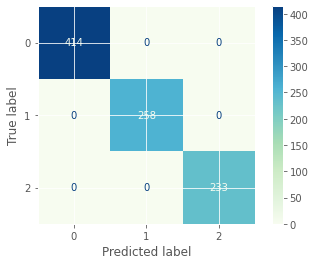

In [ ]:
confusion_matrix = metrics.plot_confusion_matrix(reg, X_test, y_test, cmap = 'GnBu')
confusion_matrix

In [ ]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


Great! Our Logistic regression model made no mistakes and performed with 100 percent accuracy. 

# Poisson model

Let's try something different - Poisson model. 
We already know that Logistic Regression is used to model the probability of a certain class or event such as win/lose.
But, what happens when the questions are “How many goals the team will score playing against the other team?”. One way to answer these questions is using the Poisson Regression Model.

In [ ]:
team_vs_team

,season,home_team,home_team_goal,away_team,away_team_goal
0,2008/2009,Newcastle United,2,West Bromwich Albion,1
1,2008/2009,Newcastle United,2,Aston Villa,0
2,2008/2009,Newcastle United,2,Wigan Athletic,2
3,2008/2009,Newcastle United,2,Stoke City,2
4,2008/2009,Newcastle United,2,Tottenham Hotspur,1
...,...,...,...,...,...
3035,2014/2015,Burnley,0,Leicester City,1
3036,2014/2015,Burnley,0,Stoke City,0
3037,2014/2015,Burnley,0,Sunderland,0
3038,2014/2015,Burnley,1,West Ham United,3


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson,skellam

In [ ]:
goal_model_data = pd.concat([
            #playing at home 
            team_vs_team[['home_team','away_team','home_team_goal']].assign(home=1).rename(
            columns={'home_team':'team', 'away_team':'opponent','home_team_goal':'goals'}),
            #playing away
            team_vs_team[['home_team','away_team','away_team_goal']].assign(home=0).rename(
            columns={'away_team':'team', 'home_team':'opponent','away_team_goal':'goals'})])

In [ ]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

#Goal predictions
Let's see goal predictions for Newcastle United and Aston Villa.
From our data frame, Aston Villa won two times against Newcastle United when they played at home and never scored more than one goal. In our dataset, there is no recorded victory when the team played away - in New Castle.

In [ ]:
# Aston Villa playing at home
poisson_model.predict(pd.DataFrame(data={'team': 'Aston Villa', 'opponent': 'Newcastle United',
                                       'home':1},index=[1]))

1    1.473353
dtype: float64

In [ ]:
# Aston Villa playing away
poisson_model.predict(pd.DataFrame(data={'team': 'Newcastle United', 'opponent': 'Aston Villa',
                                       #indicates playing away
                                       'home':0},index=[1]))

1    1.174157
dtype: float64

In [ ]:
#@title
av_vs_nu = pd.read_sql('''SELECT 
th.team_long_name as home_team,
Match.home_team_goal,
ta.team_long_name as away_team,
Match.away_team_goal
FROM Match
JOIN Team AS ta ON Match.away_team_api_id = ta.team_api_id
JOIN Team AS th ON Match.home_team_api_id = th.team_api_id
WHERE Match.country_id = 1729
AND home_team = 'Aston Villa'
AND away_team = 'Newcastle United'

ORDER BY Match.home_team_api_id desc''', con)
av_vs_nu

,home_team,home_team_goal,away_team,away_team_goal
0,Aston Villa,1,Newcastle United,0
1,Aston Villa,1,Newcastle United,0
2,Aston Villa,1,Newcastle United,1
3,Aston Villa,1,Newcastle United,2
4,Aston Villa,1,Newcastle United,2
5,Aston Villa,0,Newcastle United,0
6,Aston Villa,0,Newcastle United,0


In [ ]:
#@title
nu_vs_av = pd.read_sql('''SELECT 
th.team_long_name as home_team,
Match.home_team_goal,
ta.team_long_name as away_team,
Match.away_team_goal
FROM Match
JOIN Team AS ta ON Match.away_team_api_id = ta.team_api_id
JOIN Team AS th ON Match.home_team_api_id = th.team_api_id
WHERE Match.country_id = 1729
AND home_team = 'Newcastle United'
AND away_team = 'Aston Villa' 

ORDER BY Match.home_team_api_id desc''', con)
nu_vs_av

,home_team,home_team_goal,away_team,away_team_goal
0,Newcastle United,2,Aston Villa,0
1,Newcastle United,6,Aston Villa,0
2,Newcastle United,2,Aston Villa,1
3,Newcastle United,1,Aston Villa,1
4,Newcastle United,1,Aston Villa,0
5,Newcastle United,1,Aston Villa,0
6,Newcastle United,1,Aston Villa,1


I'm not quite happy with model accuracy: we can see that Aston Villa never scored more than one goal against Newcastle, yet our model predicts 1.47 goal. 

Our model is too optimistic? 

# Who will win the match?

In our dataframe, we can find information about betting odds given for that particular match. We will use the gambling company's 'B365' odds: B365H - shows the odds of the home team winning; B365D stands for 'draw, and B365A - for away team victory. 

In [ ]:
B365_odds = pd.read_sql('''SELECT 
Match.date,
th.team_long_name as home_team,
ta.team_long_name as away_team,
Match.B365H,
Match.B365D,
Match.B365A
FROM Match
JOIN Team AS ta ON Match.away_team_api_id = ta.team_api_id
JOIN Team AS th ON Match.home_team_api_id = th.team_api_id
WHERE Match.country_id = 1729
ORDER BY Match.home_team_api_id desc''', con)
B365_odds

,date,home_team,away_team,B365H,B365D,B365A
0,2008-10-28 00:00:00,Newcastle United,West Bromwich Albion,1.83,3.50,4.50
1,2008-11-03 00:00:00,Newcastle United,Aston Villa,3.00,3.30,2.38
2,2008-11-15 00:00:00,Newcastle United,Wigan Athletic,2.10,3.30,3.60
3,2008-12-06 00:00:00,Newcastle United,Stoke City,1.80,3.50,4.75
4,2008-12-21 00:00:00,Newcastle United,Tottenham Hotspur,2.37,3.40,3.00
...,...,...,...,...,...,...
3035,2015-04-25 00:00:00,Burnley,Leicester City,2.63,3.30,2.90
3036,2015-05-16 00:00:00,Burnley,Stoke City,2.70,3.30,2.88
3037,2014-09-20 00:00:00,Burnley,Sunderland,2.50,3.30,3.10
3038,2014-10-18 00:00:00,Burnley,West Ham United,2.80,3.40,2.70


Now, how can we compare these percents to the probabilities returned by our model? 

Well, decimal odds can be converted to probabilities quite easily: it’s simply the inverse of the decimal odds. For example, the probability of Aston winning is 1/1.13 = 0.889 

Here are the results:

In [ ]:
give_odds('Newcastle United', 'Aston Villa')

B365H    2.274286
B365D    3.442857
B365A    3.840000
dtype: float64

In [ ]:
count_probability('Newcastle United', 'Aston Villa')

'home_win 2.099430906388593, draw 3.976687667888407, away_win 3.7635147150972315.'

In the match Newcastle United vs. Aston Villa we can see that B365 gambling company gave 2,274 'decimal odds' for Newcastle victory, and our Poisson model gave 2.09

For a draw 'situation' we have 3.44 vs 3.97
And for Aston Villa victory we have 3.8 vs 3.76.

I think that's not far off.  Let's take another match to evaluate further.

In [ ]:
give_odds('Sunderland', 'Liverpool')

B365H    4.37875
B365D    3.53750
B365A    1.98000
dtype: float64

In [ ]:
count_probability('Sunderland', 'Liverpool')

'home_win 3.9750552624319004, draw 3.9660122365874444, away_win 2.040930014949179.'

Sunderland playing against Liverpool.
Sunderland wins - 4.37 vs 3.97;
draw 3.53 vs 3.96
Liverpool wins - 1.98 vs 2.04

Well, it seems our model is more optimistic about Liverpool, yet it again did not contradict any of B365 predictions! 

Our model was created on the belief that the number of goals can be expressed as a Poisson distribution. If that assumption is misguided, then the model outputs will be unreliable. In football terms, according to our Poisson model, there should be an equal number of goals in the first and second halves. Unfortunately, that doesn’t happen in the 'wild'.

# Summary

After much hard work we can tell our boss that we are ready to place some bets! We can now use our logistic regression model utilizing many stats gathered from previous match data and check how far off our odds are compared to other betting company's odds with Poisson.

There is a chance that bivariate Poisson distribution ar Weibull distribution would yield a better result.
In conclusion, despite its flaws, it recreates several features that are good to have for any model predicting sports events based on home advantage, varying offensive strengths, and opposition quality.

# References:
https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/

https://www.geeksforgeeks.org/principal-component-analysis-with-python/

https://betfair-datascientists.github.io/modelling/EPLmlPython/